In [1]:
%pwd

'/home/acr/Documents/Projeto Sistemas Mecatrónicos/RL-SistMecatron/Resultados e Código para Relatório'

# Only runs on Python 3.7 because of the stableBaselines

# Building our own scenario

Build a reinforcement learning model to adjust the temperature automatically to get in the optimal range

Optimal temperature: Between 37 and 39 degrees
Shower Length: 60 seconds
Actions: Turn down, Leave, Turn up
Task: Build a model that keeps us in the optimal range for as long as possible

# Install Dependencies

In [33]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2
!pip install tensorflow-gpu==2.3.0 
!pip install stable_baselines 
!pip install gym
!conda install swig -y # needed to build Box2D in the pip install
!pip install box2d-py # a repackaged version of pybox2d

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.7.0rc0, 2.7.0rc1, 2.7.0)
ERROR: No matching distribution found for tensorflow==2.3.0


# Creating a random environment

#### The goal is to balance the pole up, moving the cart to the left or right . For each step it takes a point, for a maximum of 200 points

In [1]:
from gym import Env # Allows us to build our environment on top of it
from gym import spaces
from gym.spaces import Discrete, Box # Allows us to define the actions and the states of our environment
import numpy as np
import random
import time
import matplotlib.pyplot as plt

/home/acr/anaconda3/envs/p37workshop/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
class ShowerEnv(Env): # By passing Env to the showerEnv class we are inheriting the methods and properties from the OpenAI gym environment class
    metadata = {'render.modes': ['console']}
    
    def __init__(self): # We will be initializing the actions we can take, our observation space, the space, the temperature and the shower length 
        super(ShowerEnv,self).__init__()
        # Actions we can take, down, stay, up
        self.action_space=spaces.Discrete(3)
        # Temperature array
        self.observation_space = Box(low=0, high=100, shape=(1,), dtype=np.float32) # Box allows to gave a whole range of spaces
        # Set start temp (As in real life, the shower's water starts cold)
        self.state = 15 + random.randint(-3,3)
        # Set shower length
        self.shower_length = 60*5 # 10 minutes=10*60 seconds

    def reset(self):
        # Reset shower temperature
        self.state = 15 +random.randint(-3,3)
        # Reset shower time
        self.shower_length = 60*5
        return np.array([self.state]).astype(np.float32)
    
    def step(self, action): # Defines what we do whenever we take actions
        # Aplly action
        # As the action is 0,1 or 2, as we subtract 1 when temperature decreases is -1, when it stays the same is 0 and when it increases is +1
        # 0-1=-1, 1-1=0, 2-1=1
        self.state += action -1
        # Reduce shower length by 1 second
        self.shower_length -= 1
        
        #Calculate reward
        # If water is 38 it gives a reward of 2, if it is 37 or 29 it gives a reward of 1
        if self.state>= 37 and self.state<=39:
            reward= (2-abs(38-self.state))*6
        # The negative rewards will be greater if the colder the water is and the hotter the water is 
        elif self.state < 37:
            reward=-(37-self.state)*2
        elif self.state > 39:
            reward = -(self.state-39)*2
        
        # Check if shower is done
        if self.shower_length <=0 :
            done = True
        else:
            done = False                
        
        # Apply temperature noise
        self.state+=random.randint(-2,2)
        # Set placeholder for info
        info= {}
        
        # Return step information
        return np.array([self.state]).astype(np.float32), reward, done, info # self.state is the temperature
    
    def render(self): # Visualizations
        # Implement visualization
        pass
    
    def close(self):
        pass

In [3]:
env = ShowerEnv()

In [4]:
# help(env.step)

In [5]:
env.step(1)[0]

array([11.], dtype=float32)

In [6]:
env.action_space.sample()

2

In [7]:
env.observation_space.high[0]

100.0

In [8]:
env.observation_space.sample()

array([50.304707], dtype=float32)

#### Now we're just setting some random episodes where there is no learning from each of the episodes

Box([0.], [100.], (1,), float32)
Discrete(3)
1

Episode:1 Score: -13144 
Episode:2 Score: -12394 
Episode:3 Score: -4700 
Episode:4 Score: -12588 
Episode:5 Score: -14408 
Episode:6 Score: -8490 
Episode:7 Score: -13894 
Episode:8 Score: -5142 
Episode:9 Score: -33946 
Episode:10 Score: -20218 


<function matplotlib.pyplot.show(close=None, block=None)>

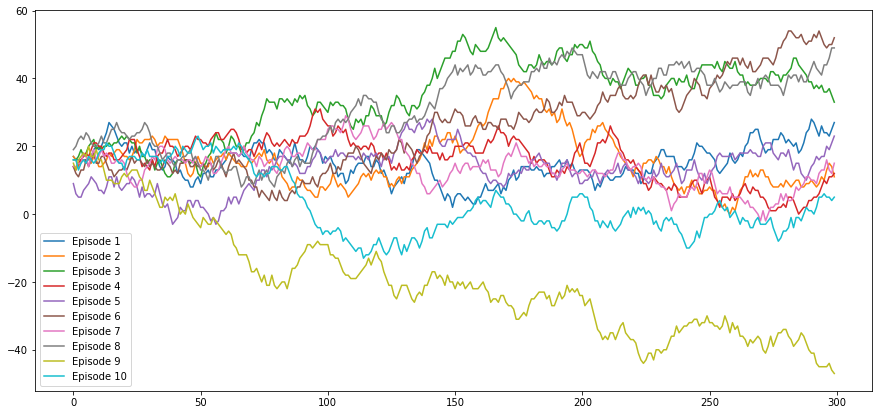

In [9]:
obs = env.reset()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())
print()

plt.figure(figsize=(15,7))
episodes = 10
for episode in range(1,episodes+1):
  state=env.reset()
  done=False
  score=0
  Temp_plot=[]

  while not done:
#     env.render() # Rendering of the screen
#     time.sleep(0.03) # Slowing the rendering. It stops 0.03 seconds for each frame
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    Temp_plot.append(obs)
    score+=reward
    info = info
    
  plt.plot(Temp_plot, label = 'Episode {}'.format(episode))
  plt.legend()
  print('Episode:{} Score: {} '.format(episode, round(score,0)))
plt.show
# env.close()   # Closing the video, otherwise the window will not close

In [10]:
# help(env.step)

# Build and Train Agent with StableBaselines

In [11]:
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.cmd_util import make_vec_env

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/acr/anaconda3/envs/p37workshop/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


Checking if the environment follows the gym interface

In [12]:
# It will check your custom environment and output additional warnings if needed
check_env(env, warn=True)

In [13]:
# help(DQN)

In [14]:
env = make_vec_env(lambda: env, n_envs=1)

In [15]:
model1 = DQN('MlpPolicy', env, verbose=1).learn(15000)







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











State: None
Action:  1
State 12.0 reward= -48.0 done= [False]
Sum of rewards: -48.0
Step: 1

State: None
Action:  1
State 15.0 reward= -48.0 done= [False]
Sum of rewards: -96.0
Step: 2

State: None
Action:  1
State 16.0 reward= -42.0 done= [False]
Sum of rewards: -138.0
Step: 3

State: None
Action:  1
State 15.0 reward= -40.0 done= [False]
Sum of rewards: -178.0
Step: 4

State: None
Action:  1
State 18.0 reward= -42.0 done= [False]
Sum of rewards: -220.0
Step: 5

State: None
Action:  1
State 20.0 reward= -36.0 done= [False]
Sum of rewards: -256.0
Step: 6

State: None
Action:  1
State 19.0 reward= -32.0 done= [False]
Sum of rewards: -288.0
Step: 7

State: None
Action:  1
State 20.0 reward= -34.0 done= [False]
Sum of rewards: -322.0
Step: 8

State: None
Action:  1
State 20.0 reward= -32.0 done= [False]
Sum of rewards: -354.0
Step: 9

State: None
Action:  1
State 20.0 reward= -32.0 done= [False]
Sum of rewards: -386.0
Step: 10

State: None
Action:  1
State 23.0 reward= -32.0 done= [False


State: None
Action:  1
State 37.0 reward= -4.0 done= [False]
Sum of rewards: -964.0
Step: 156

State: None
Action:  -1
State 34.0 reward= -2.0 done= [False]
Sum of rewards: -966.0
Step: 157

State: None
Action:  1
State 36.0 reward= -4.0 done= [False]
Sum of rewards: -970.0
Step: 158

State: None
Action:  1
State 38.0 reward= 6.0 done= [False]
Sum of rewards: -964.0
Step: 159

State: None
Action:  -1
State 36.0 reward= 6.0 done= [False]
Sum of rewards: -958.0
Step: 160

State: None
Action:  1
State 38.0 reward= 6.0 done= [False]
Sum of rewards: -952.0
Step: 161

State: None
Action:  -1
State 37.0 reward= 6.0 done= [False]
Sum of rewards: -946.0
Step: 162

State: None
Action:  -1
State 35.0 reward= -2.0 done= [False]
Sum of rewards: -948.0
Step: 163

State: None
Action:  1
State 38.0 reward= -2.0 done= [False]
Sum of rewards: -950.0
Step: 164

State: None
Action:  -1
State 35.0 reward= 6.0 done= [False]
Sum of rewards: -944.0
Step: 165

State: None
Action:  1
State 38.0 reward= -2.0 do

<function matplotlib.pyplot.show(close=None, block=None)>

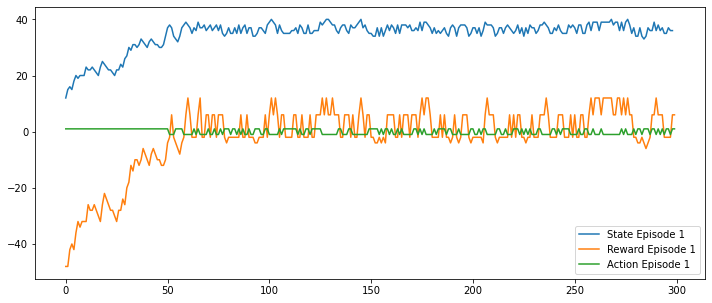

In [16]:
episodes =1
for episode in range(1,episodes+1):
  obs=env.reset()
  done=False
  state_batch = []
  reward_batch = []
  action_batch = []
  total_rewards = 0
  total_rewards_list= []
  step = 0
    
  while not done:
    step+=1
    action, obs = model1.predict(obs)
    print('\nState:',obs)
    print("Action: ", action[0]-1)
    action_batch.append(action-1)
    obs, rewards, done, info = env.step(action)
    print('State', obs[0][0], 'reward=', rewards[0], 'done=', done)
    state_batch.append(obs[0][0])
    reward_batch.append(rewards)
    total_rewards += rewards
    total_rewards_list.append(total_rewards[0])
    print('Sum of rewards:', total_rewards[0])
    print('Step:', step)

  plt.figure(figsize=(12,5))  
  plt.plot(state_batch[:-1], label='State Episode {}'.format(episode))
  plt.plot(reward_batch,label='Reward Episode {}'.format(episode))
  plt.plot(action_batch, label='Action Episode {}'.format(episode))
#   plt.plot(total_rewards_list, label='Sum of rewards Episode {}'.format(episode))
  plt.legend()
plt.show

In [17]:
# print(state_batch)

In [18]:
# model2 = DQN('MlpPolicy', env, verbose=1).learn(500000)
model2 = DQN.load("DQN_RL_Example_Custom_Scenario_Variations_1action_Noise_Baselines_RewardsTweak_model_500kSteps", env=env)

In [19]:
# model2.save("DQN_RL_Example_Custom_Scenario_Variations_1action_Noise_Baselines_RewardsTweak_model_500kSteps")

In [20]:
# del model2

In [21]:
# model2 = DQN.load("DQN_RL_Example_Custom_Scenario_Variations_1action_Noise_Baselines_RewardsTweak_model_500kSteps", env=env)


State: None
Action:  1
State 15.0 reward= -44.0 done= [False]
Sum of rewards: -44.0
Step: 1

State: None
Action:  1
State 15.0 reward= -42.0 done= [False]
Sum of rewards: -86.0
Step: 2

State: None
Action:  1
State 16.0 reward= -42.0 done= [False]
Sum of rewards: -128.0
Step: 3

State: None
Action:  1
State 15.0 reward= -40.0 done= [False]
Sum of rewards: -168.0
Step: 4

State: None
Action:  1
State 15.0 reward= -42.0 done= [False]
Sum of rewards: -210.0
Step: 5

State: None
Action:  1
State 16.0 reward= -42.0 done= [False]
Sum of rewards: -252.0
Step: 6

State: None
Action:  1
State 19.0 reward= -40.0 done= [False]
Sum of rewards: -292.0
Step: 7

State: None
Action:  1
State 20.0 reward= -34.0 done= [False]
Sum of rewards: -326.0
Step: 8

State: None
Action:  1
State 21.0 reward= -32.0 done= [False]
Sum of rewards: -358.0
Step: 9

State: None
Action:  1
State 22.0 reward= -30.0 done= [False]
Sum of rewards: -388.0
Step: 10

State: None
Action:  1
State 25.0 reward= -28.0 done= [False


State: None
Action:  0
State 41.0 reward= 6.0 done= [False]
Sum of rewards: 394.0
Step: 153

State: None
Action:  -1
State 38.0 reward= -2.0 done= [False]
Sum of rewards: 392.0
Step: 154

State: None
Action:  0
State 40.0 reward= 12.0 done= [False]
Sum of rewards: 404.0
Step: 155

State: None
Action:  -1
State 40.0 reward= 6.0 done= [False]
Sum of rewards: 410.0
Step: 156

State: None
Action:  -1
State 41.0 reward= 6.0 done= [False]
Sum of rewards: 416.0
Step: 157

State: None
Action:  -1
State 40.0 reward= -2.0 done= [False]
Sum of rewards: 414.0
Step: 158

State: None
Action:  -1
State 40.0 reward= 6.0 done= [False]
Sum of rewards: 420.0
Step: 159

State: None
Action:  -1
State 38.0 reward= 6.0 done= [False]
Sum of rewards: 426.0
Step: 160

State: None
Action:  0
State 39.0 reward= 12.0 done= [False]
Sum of rewards: 438.0
Step: 161

State: None
Action:  0
State 37.0 reward= 6.0 done= [False]
Sum of rewards: 444.0
Step: 162

State: None
Action:  1
State 38.0 reward= 12.0 done= [False

<function matplotlib.pyplot.show(close=None, block=None)>

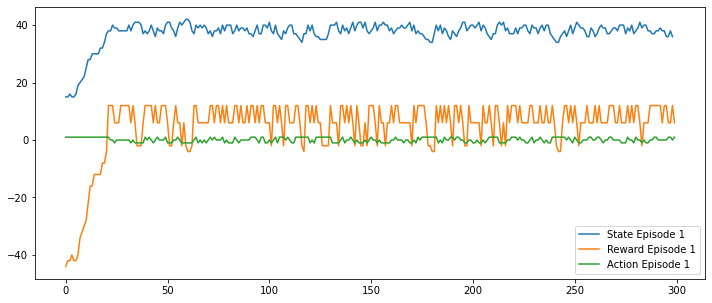

In [22]:
episodes =1
for episode in range(1,episodes+1):
  obs=env.reset()
  done=False
  state_batch = []
  reward_batch = []
  action_batch = []
  total_rewards = 0
  total_rewards_list= []
  step = 0
    
  while not done:
    step+=1
    action, obs = model2.predict(obs)
    print('\nState:',obs)
    print("Action: ", action[0]-1)
    action_batch.append(action-1)
    obs, rewards, done, info = env.step(action)
    print('State', obs[0][0], 'reward=', rewards[0], 'done=', done)
    state_batch.append(obs[0][0])
    reward_batch.append(rewards)
    total_rewards += rewards
    total_rewards_list.append(total_rewards[0])
    print('Sum of rewards:', total_rewards[0])
    print('Step:', step)

  plt.figure(figsize=(12,5))  
  plt.plot(state_batch[:-1], label='State Episode {}'.format(episode))
  plt.plot(reward_batch,label='Reward Episode {}'.format(episode))
  plt.plot(action_batch, label='Action Episode {}'.format(episode))
#   plt.plot(total_rewards_list, label='Sum of rewards Episode {}'.format(episode))
  plt.legend()
plt.show

# Create a Deep Learning Model with Keras

#### Ideally we want to take the score of each episode all the way up to 200. The deep RL is going to learn the best action to take in that specific environment to maximize the score

In [23]:
import numpy as np
import tensorflow  #allows a sequential model with Keras
# It's better to import tensorflow and use sequential than specifically importing the sequential from tensorlfow.keras.model
from tensorflow.keras.layers import Dense, Flatten # We've imported the dense and flattten nodes
from tensorflow.keras.optimizers import Adam # We've imported the optimizer Adam to train the deep learning model

In [24]:
states = env.observation_space.shape
actions = env.action_space.n

In [25]:
states

(1,)

In [26]:
env.observation_space

Box([0.], [100.], (1,), float32)

In [27]:
def build_model3layers(states, actions):
  model = tensorflow.keras.Sequential()  # initiating a sequential model
  model.add(Dense(24, activation='relu', input_shape=states))
  model.add(Dense(24, activation='relu'))
  model.add(Dense(24, activation='relu'))
  model.add(Dense(actions, activation='linear')) # This makes sure that the output are the actions. First (or through the top), come the states and lastly comes the acitons
  return model
# This model is fed the states and gets out the actions, and it trains in order to maximize the reward

In [28]:
del model_a

NameError: name 'model_a' is not defined

In [ ]:
model_a = build_model3layers(states,actions)

In [ ]:
model_a.summary() # The final output will have 3 actions. Decreasing, staying the same and increasing the temperature